# Check GPU

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Programing (E:)/Nhập Môn CV/Team/Mid-Term Report'

/content/drive/.shortcut-targets-by-id/1uJ336XEgQYZ4EctzzIjrNI5gtBJPe6QE/Team/Mid-Term Report


In [ ]:
!nvidia-smi

Sat Oct 30 02:54:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Package

In [3]:
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch
import os
from torchvision.models import vgg16
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from translate import translate
import warnings

warnings.filterwarnings('ignore')

# Data preprocessing

In [4]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = './data/animals10'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x])
                    for x in ['train','val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=16)
                for x in ['train','val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = [translate[x] for x in image_datasets['train'].classes]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
class_names, dataset_sizes

(['dog',
  'horse',
  'elephant',
  'butterfly',
  'chicken',
  'cat',
  'cow',
  'sheep',
  'spider',
  'squirrel'],
 {'test': 2000, 'train': 4000, 'val': 1000})

# Visualize data

In [7]:
def img_show(imgs, labels):
    num_img = len(imgs)
    # plt.figure(figsize=(20*num_img, 20))
    fig, ax = plt.subplots(1, num_img, figsize=(7*num_img, 7))
    # fig.figsize = (20*num_img, 20)
    for i, img in enumerate(imgs):
        img = img.numpy().transpose(1, 2, 0)
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax[i].axis('off')
        ax[i].imshow(img)
        ax[i].set_title(labels[i])
      

    plt.show()

In [8]:
import pandas as pd
import seaborn as sns
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
mpl.style.use('seaborn')

def draw_cf_matrix(cf_matrix, classes):
    sum = cf_matrix.sum()
    cf_matrix = cf_matrix * 1000.0 / ( 1.0 * sum )

    df_cm = pd.DataFrame(cf_matrix, 
    index = classes,
    columns = classes)

    fig = plt.figure()
    plt.clf()

    ax = fig.add_subplot(111)
    ax.set_aspect(1)

    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    res = sns.heatmap(df_cm, annot=True, vmin=0.0, vmax=100.0, fmt='.2f', cmap=cmap)
    # res.invert_yaxis()
    plt.yticks(ticks=list(range(len(classes))), labels=classes, va='center')
    plt.title('Confusion Matrix')

    plt.show()

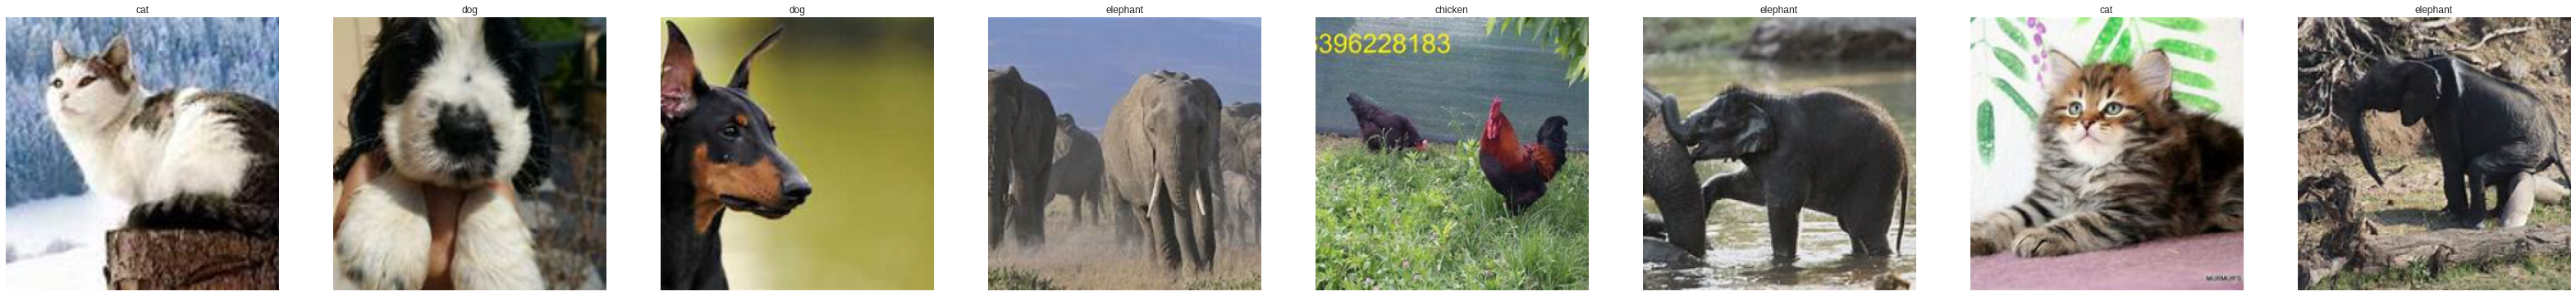

In [9]:
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
img_show(inputs, [class_names[x] for x in classes])

# Define model

## Load VGG16 as base model

In [10]:
base_model = models.alexnet(pretrained=True).to('cuda')
summary(base_model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [11]:
list(base_model.classifier.children())

[Dropout(p=0.5, inplace=False),
 Linear(in_features=9216, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Linear(in_features=4096, out_features=1000, bias=True)]

## Modify the last layer of model to use as Feature Extractor

In [12]:
class Alexnet_custom(nn.Module):
  def __init__(self):
    super(Alexnet_custom, self).__init__()
    self.features = nn.Sequential(*list(base_model.features.children()))
    self.avgpool = base_model.avgpool
    self.classifier = nn.Sequential(*list(base_model.classifier.children())[: -1])

  def forward(self,x):
    x = self.features(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1) # Flatten
    x = self.classifier(x)
    return x

model_custom = Alexnet_custom().to('cuda')
summary(model_custom, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

# Define Extractor function

In [13]:
def extract(model, dataloader):
    X_train = torch.tensor([]).to('cuda')
    y_train = torch.tensor([]).to('cuda')
    X_test = torch.tensor([]).to('cuda')
    y_test = torch.tensor([]).to('cuda')

    with torch.no_grad():
        for data in ['train', 'test']:
            for x, y in dataloaders[data]:
                x = x.to('cuda')
                y = y.to('cuda')
                model.eval()
                out = model(x)
                if data == 'train':
                    X_train = torch.cat((X_train, out),dim=0)
                    y_train = torch.cat((y_train, y), dim=0)
                else:
                    X_test = torch.cat((X_test, out),dim=0)
                    y_test = torch.cat((y_test, y), dim=0)

    X_train = X_train.cpu().detach().numpy()
    y_train = y_train.cpu().detach().numpy()
    X_test = X_test.cpu().detach().numpy()
    y_test = y_test.cpu().detach().numpy()

    return X_train, X_test, y_train, y_test

In [14]:
X_train, X_test, y_train, y_test = extract(model_custom, dataloaders)

# SVM rbf

In [15]:
from sklearn import svm
svm_model = svm.SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## Evaluate model

In [16]:
y_pred = svm_model.predict(X_test)

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
print('Accuracy: ', accuracy_score(y_pred, y_test))
print('Recall: ',recall_score(y_pred, y_test,average='micro'))
print('Precision: ',precision_score(y_pred, y_test,average='micro'))
print('F1: ',f1_score(y_pred, y_test,average='micro'))

Accuracy:  0.896
Recall:  0.896
Precision:  0.896
F1:  0.8960000000000001


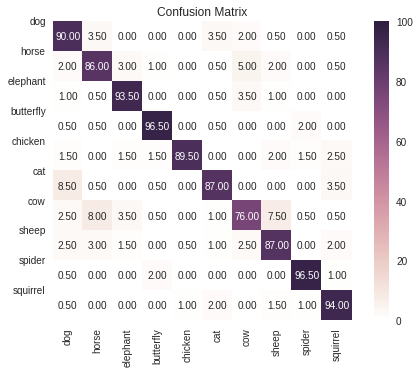

In [18]:
cf_matrix = confusion_matrix(y_test, y_pred)

draw_cf_matrix(cf_matrix, class_names)

# SVM sigmoid

In [19]:
from sklearn import svm
svm_model = svm.SVC(kernel='sigmoid')
svm_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## Evaluate model

In [20]:
y_pred = svm_model.predict(X_test)

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
print('Accuracy: ', accuracy_score(y_pred, y_test))
print('Recall: ',recall_score(y_pred, y_test,average='micro'))
print('Precision: ',precision_score(y_pred, y_test,average='micro'))
print('F1: ',f1_score(y_pred, y_test,average='micro'))

Accuracy:  0.8835
Recall:  0.8835
Precision:  0.8835
F1:  0.8835000000000001


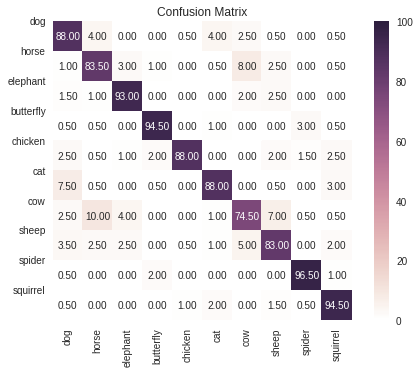

In [22]:
cf_matrix = confusion_matrix(y_test, y_pred)

draw_cf_matrix(cf_matrix, class_names)

# SVM poly

In [23]:
from sklearn import svm
svm_model = svm.SVC(kernel='poly')
svm_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## Evaluate model

In [24]:
y_pred = svm_model.predict(X_test)

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
print('Accuracy: ', accuracy_score(y_pred, y_test))
print('Recall: ',recall_score(y_pred, y_test,average='micro'))
print('Precision: ',precision_score(y_pred, y_test,average='micro'))
print('F1: ',f1_score(y_pred, y_test,average='micro'))

Accuracy:  0.8145
Recall:  0.8145
Precision:  0.8145
F1:  0.8145


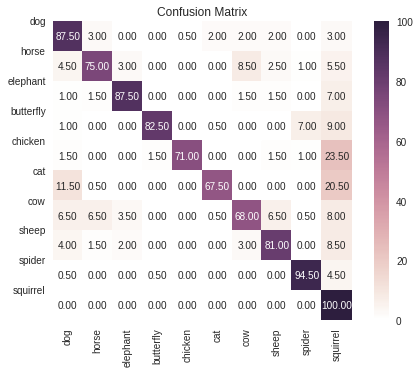

In [26]:
cf_matrix = confusion_matrix(y_test, y_pred)

draw_cf_matrix(cf_matrix, class_names)

# SVM linear

In [27]:
from sklearn import svm
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## Evaluate model

In [28]:
y_pred = svm_model.predict(X_test)

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
print('Accuracy: ', accuracy_score(y_pred, y_test))
print('Recall: ',recall_score(y_pred, y_test,average='micro'))
print('Precision: ',precision_score(y_pred, y_test,average='micro'))
print('F1: ',f1_score(y_pred, y_test,average='micro'))

Accuracy:  0.8765
Recall:  0.8765
Precision:  0.8765
F1:  0.8765


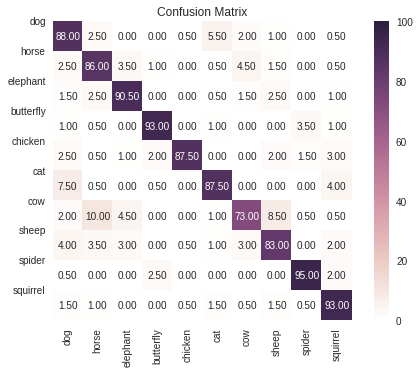

In [30]:
cf_matrix = confusion_matrix(y_test, y_pred)

draw_cf_matrix(cf_matrix, class_names)

# Test model

In [ ]:
def extract_test(model, x):
    with torch.no_grad():
        features = torch.tensor([]).to('cuda')
        x = x.to('cuda')
        model.eval()
        features = model(x)
    return features.cpu().detach().numpy()

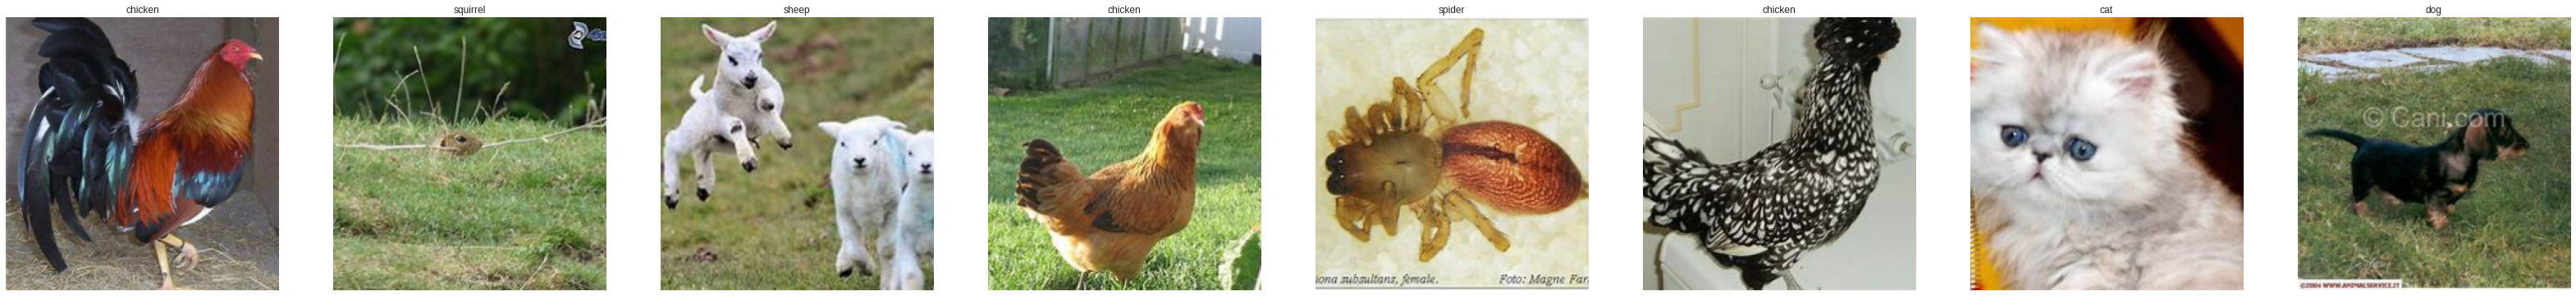

In [ ]:
inputs, classes = next(iter(dataloaders['test']))

features = extract_test(model_custom, inputs)
preds = svm_model.predict(features)

img_show(inputs, [class_names[x] for x in preds.astype(int)])